In [1]:
import pandas as pd
import numpy as np
import os, sys
sys.path.insert(0, os.path.abspath('../..'))
import source.data_preparation as dp



In [2]:
data = dp.load_data()
data = dp.format_date(data)
data = dp.calc_equity_premium(data)


/Users/kilianrunnwerth/Desktop/Python/Kaggel/.conda/lib/python3.11/site-packages/openpyxl/worksheet/header_footer.py:48: UserWarning: Cannot parse header or footer so it will be ignored
  warn("""Cannot parse header or footer so it will be ignored""")


In [3]:
data.head()

,price,d12,e12,ret,retx,AAA,BAA,lty,ltr,corpr,...,rsvix,gpce,gip,tchi,house,avgcor,shtint,disag,date,equity_premium
0,4.44,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1871-01-01,NaN
1,4.50,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1871-02-01,NaN
2,4.61,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1871-03-01,NaN
3,4.74,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1871-04-01,NaN
4,4.86,0.26,0.4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1871-05-01,NaN


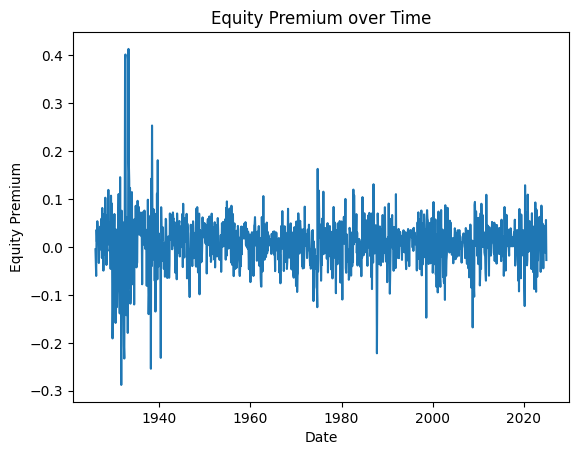

In [6]:
#create a plot of the equity premium over time
import matplotlib.pyplot as plt
plt.plot(data['date'], data['equity_premium'])
plt.xlabel('Date')
plt.ylabel('Equity Premium')
plt.title('Equity Premium over Time')
plt.show()


In [4]:
# good predictiors tchi, shint,  gpce, tby, ity


In [10]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

df = data.copy()
df['equity_premium'] = df['ret'] - df['Rfree']
df['dp_lag'] = df['d/p'].shift(1)
df = df.dropna(subset=['equity_premium', 'dp_lag'])
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date').sort_index()

start_oos = pd.Timestamp('1965-01-01')
predictions, actuals = [], []

for t, date_t in enumerate(df.index):
    if date_t < start_oos:
        continue
    est = df.loc[:date_t].iloc[:-1]
    if len(est) < 30:
        continue

    X = sm.add_constant(est['dp_lag'])
    y = est['equity_premium']
    model = sm.OLS(y, X).fit()

    # ✅ fixed prediction line
    X_pred = pd.DataFrame({'const': [1.0], 'dp_lag': [df.loc[date_t, 'dp_lag']]})
    pred = model.predict(X_pred)[0]

    predictions.append(pred)
    actuals.append(df.loc[date_t, 'equity_premium'])

predictions = np.array(predictions)
actuals = np.array(actuals)

mean_forecast = np.array([actuals[:i].mean() for i in range(1, len(actuals)+1)])
r2_oos = 1 - np.sum((actuals - predictions)**2) / np.sum((actuals - mean_forecast)**2)
print(f"Out-of-sample R²: {r2_oos:.4f}")


Out-of-sample R²: -0.0131
